<a href="https://colab.research.google.com/github/arpanbiswas52/MOBO_PhysicsBasedModels/blob/main/PhysicsDrivenDecisionTree(PZO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Automated Task: From numerical model to physics driven decision-tree developement

- Domain Concept -- **Sergei V. Kalilin** and **Anna N. Morozovska**
- Theoritical Model (2-4-6 KLGD for bulk PZO) as presented in the paper (link provided below), proposed by -- **Anna N. Morozovska**  developed by -- **Eugene A. Eliseev** (in Mathematica) and **Arpan Biswas** (in Python)
- Hysteresis loop generation, decision-tree generation and evaluation from loops-- **Arpan Biswas**


Paper cite for equations and parameters used to develop anti-ferroelectric PZO materials: https://arxiv.org/abs/2106.13096

Paper cite for schematic of physics based decision tree: https://arxiv.org/abs/2108.12889

Import functions

In [1]:
#Import classical numpy and torch
import torch as to
import numpy as np
#Plotting
import matplotlib.pyplot as plt
#Random # generator
import random

#Import functions required for configure hysteresis loops from PZO model and automated task to develop decision tree of functionalities from loop structures
from numpy import linalg as LA
from scipy import optimize
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

#other math functions
from scipy.stats import norm

Define function to calculate free energy using parameters for bulk PZO material (2-4-6 KLGD).

**Note** - To work with different numerical models, need to replace this section with an appropiate user defined models 

In [2]:
####################### Calculate free energy######################
def AFIloop(x, T, rho, h, dG, e):

    alpha_pt = 2.7969*10**5
    alpha_at = 4.8789*10**6
    Tp = 463.2
    Ta = 490
    beta_p = -3.825*10**8
    beta_a = -2.056*10**9
    xhi = 1.7754*10**10
    #xhi =0
    gamma_p = 3.126*10**9
    gamma_a = 2.28*10**10
    #gamma_p = 0
    #gamma_a = 0
    h=h*10**-9
    epsilon_b = 7
    l_da = 2*10**-9
    epsilon_d = 10
    epsilon_0 = 8.85*10**-12
    charge = 1.6*10**-19
    Z = [2, -2]
    n = [2, -2]
    Ai = [10**-18, 10**-18]
    kb = 1.38*10**-23
    delta_G = dG*charge
    U0= 5

    f1 = (1 + np.exp(delta_G / (kb * T)) * rho ** (1 / n[0])) ** (-1)
    f2 = (1 + np.exp(delta_G / (kb * T)) * rho ** (1 / n[1])) ** (-1)
    screen = ((l_da * h) / (epsilon_0 * ((epsilon_d * h) + (l_da * epsilon_b)))) * (((charge * Z[0] * f1) ** 2 / (Ai[0] * kb * T)) + ((charge * Z[1] * f2) ** 2 / (Ai[1] * kb * T)))
    Esi = (l_da / (epsilon_0 * ((epsilon_d * h) + (l_da * epsilon_b)))) * (((charge * Z[0] * f1) / Ai[0]) + ((charge * Z[1] * f1) / Ai[1]))
    # Ea = -(epsilon_d*U)/((epsilon_d*h) + (l_da*epsilon_b))
    # Eff = 0
    E = e / 10 ** -9
    Eff = Esi + E
    alpha_p = alpha_pt * (T - Tp)
    alpha_a = alpha_at * (T - Ta)
    alpha_pr = alpha_p * (1 + screen) + ((l_da * 0.5) / (epsilon_0 * ((epsilon_d * h) + (l_da * epsilon_b))))
    beta_pr = (1 + screen) * beta_p
    gamma_pr = (1 + screen) * gamma_p
    xhi_r = (1 + screen) * xhi
    En = alpha_pr * x[0] ** 2 + beta_pr * x[0] ** 4 + gamma_pr * x[0] ** 6 - Eff * x[0] + xhi_r * x[0] ** 2 * x[1] ** 2 + alpha_a * x[1] ** 2 + beta_a * x[1] ** 4 + gamma_a * x[1] ** 6

    return En

<h1> Physics driven Decision tree description

For chosen parameters of a material (eg. 2-4-6 KLGD for bulk PZO), we can get different loop structures such as zero loop, one loop and two loops which defines different phases like paraelectric (PE), ferroelectric (FE) and anti-ferroelectric (AFE) respectively. For each of these phases, we have different classifications. For example, if the phase is PE, we then classify the hysteresis curve as linear, sigmoid and two waves. If the phase is AFE, we further classify as the two loops are attached or not, with quantifying the distance between separation between the loops. If the phase is FE, we have two different classifications. The first one is the measure of the shift of the loops, and in positive or negative direction. The second one is the measure of the width of the loop. Finally, irrespective of the loop structures, we calculate the energy storage and loss. 

Below section defines all the functions- each numerically evaluates for one branch of the decision tree.

In [3]:
####################### Classification for zero loops######################
def objzeroloop(sol,e, T, rho):
    M=1
    p_mat = sol[313:437]
    E = e[313:437]

    slope_p = np.zeros((len(p_mat)-1))
    for i in range(0, len(p_mat)-1):
        p1 = p_mat[i]
        p2 = p_mat[i+1]
        slope_p[i]= (p1-p2)
    pks, pks_ht = find_peaks(slope_p, height=0.7*max(slope_p), distance=5)
    # number of peaks will determine the curve, for linear the slope is constant and wont have any peaks, for sigmoid 1 peaks, for wavy >1 peaks
    if (max(slope_p)<=1e-3) or ((max(slope_p)-min(slope_p))<1e-3): #linear, no sudden peaks
        index= range(0,len(pks))
        pks = np.delete(pks,index)

    npks = len(pks)
    if (npks > 2): #This to avoid in the loop structure when we sometimes get some impractical peaks due to convergence issues
        npks =2

    if (npks ==2):
        objeval = (npks + slope_p[pks[0]] + slope_p[pks[1]]) * M
    elif (npks==1):
        objeval = (npks + slope_p[pks[0]]) * M
    else:
        objeval = npks*M

    return objeval

####################### Classification for one loop######################
def objoneloop(sol,e, T, rho):
    M=1
    # In some cases for the limit of field interval, loop does not form fully- to avoid calculation issue for S.E and E.L,
    # we add the 1st step of the other half cycle and calculate the area- if the loop is formed for the E interval,
    # we add negligible area for this additional step as p(t+1) - p(t-1) is negligible in that case (using quadrature method for numerical integration)
    p_mats = sol[313:437]
    p_mats = np.hstack((p_mats, sol[188]))
    p_matt = sol[188:312]
    p_matt = np.hstack((p_matt, sol[313]))
    Es = e[313:437]
    Es = np.hstack((Es, e[188]))
    Et = e[188:312]
    Et = np.hstack((Et, e[313]))
    Emax = max(e[188:437])
    Emin = min(e[188:437])
    a_ps = np.zeros((len(p_mats)-1))
    a_pt = np.zeros((len(p_matt) - 1))
    for i in range(0, len(p_mats)-1):
        p1s = p_mats[i]
        p2s = p_mats[i+1]
        e1s = Es[i]
        e2s = Es[i+1]
        p1t = p_matt[i]
        p2t = p_matt[i+1]
        e1t = Et[i]
        e2t = Et[i+1]
        a_ps[i] = 0.5*np.absolute(p1s-p2s)*np.absolute(e1s-e2s) + np.absolute(p1s-p2s)*np.absolute(e2s-Emin)
        a_pt[i] = 0.5*np.absolute(p2t-p1t)*np.absolute(e2t-e1t) + np.absolute(p2t-p1t)*np.absolute(e1t-Emin)

    As = sum(a_ps)
    At = sum(a_pt)
    #Find build-in and coercive field
    iminabsp_mats = np.argmin(np.absolute(p_mats))
    iminabsp_matt = np.argmin(np.absolute(p_matt))
    Ec1 = Et[iminabsp_matt]
    Ec2 = Es[iminabsp_mats]
    lshift = 0.5*(Ec1 + Ec2)
    lwidth = (Ec1 - Ec2)
    objeval1 = lshift
    if (lwidth<0):
        objeval2 =0
    else:
        objeval2 =lwidth

    return objeval1, objeval2

####################### Classification for two loops######################
def objtwoloop(sol, diff_P, e,T,rho):
    M=1
    p_mat1 = sol[313:437]
    p_mat2 = np.flip(sol[188:312])
    E = e[313:437]
    d_p = (p_mat1 - p_mat2)
    zero_crossings = np.where(np.diff(np.sign(d_p)))[0]
    if (len(zero_crossings)==4):
        E_right= E[zero_crossings[1]+1]
        P_right = p_mat1[zero_crossings[1]+1]
        E_left = E[zero_crossings[2]]
        P_left = p_mat1[zero_crossings[2]]
        if ((p_mat1[zero_crossings[0]+1]>P_right) and (P_left>p_mat1[zero_crossings[3]])):
            E_length = np.absolute(E_right-E_left)
            P_length = np.absolute(P_right-P_left)
            loop_dist = np.sqrt(E_length**2 + P_length**2)
            objeval = loop_dist*M
        else:
            objeval = 0 #Avoiding cal loop distance for loops with some impractical spikes- May be better way to compute (will visit in future)
    else:
        objeval =0

    return objeval

####################### Classification for # of loops######################
def objnumloop(sol, diff_P, e):
    M=1
    d_p = diff_P[313:437] #Last half cycle
    pks, pks_ht = find_peaks(d_p, height=0.7*max(d_p), distance=5)
    if (max(d_p)<=1e-3) or ((max(d_p)-min(d_p))<1e-3):
        index= range(0,len(pks))
        pks = np.delete(pks,index)

    npks = len(pks)
    if (npks > 2): #This to avoid in the loop structure when we sometimes get some impractical peaks due to convergence issues
        npks =2

    objeval1 = npks*M

    return objeval1

####################### Calculate energy storage and loss######################
def calstorage(sol, e, T, rho):
    p_mats = sol[313:437]
    p_mats = np.hstack((p_mats, sol[188]))
    p_matt = sol[188:312]
    p_matt = np.hstack((p_matt, sol[313]))
    Es = e[313:437]
    Es = np.hstack((Es, e[188]))
    Et = e[188:312]
    Et = np.hstack((Et, e[313]))
    Emax = max(e[188:437])
    Emin = min(e[188:437])
    a_ps = np.zeros((len(p_mats) - 1))
    a_pt = np.zeros((len(p_matt) - 1))
    for i in range(0, len(p_mats) - 1):
        p1s = p_mats[i]
        p2s = p_mats[i + 1]
        e1s = Es[i]
        e2s = Es[i + 1]
        p1t = p_matt[i]
        p2t = p_matt[i + 1]
        e1t = Et[i]
        e2t = Et[i + 1]
        a_ps[i] = 0.5 * np.absolute(p1s - p2s) * np.absolute(e1s - e2s) + np.absolute(p1s - p2s) * np.absolute(e2s - Emin)
        a_pt[i] = 0.5 * np.absolute(p2t - p1t) * np.absolute(e2t - e1t) + np.absolute(p2t - p1t) * np.absolute(e1t - Emin)

    As = sum(a_ps)
    At = sum(a_pt)
    Al = At-As
    if (Al < -1e3):  # To avoid numerical issue for any impractical peaks or loops not formed for the given E interval, making Stored energy >> Total energy
        As = -1
        Al = -1
    return As, Al

Below function integrates all the above defined functions and quantifies the overall physics-driven decision tree

In [4]:
def funoptimize(T, rho, h, dG, e):

    niter=len(e)
    sol=np.zeros(niter)
    diff_P=np.zeros(niter)
    for j in range(0, niter):
        # This is exhaustively considered as the initial points of P, A for optimization so it has more likely to locate the two extreme local minima of free energy (desired for loop). Prior info of starting values for diff problems (without exhaustive analysis) is a challenge
        P_ini= np.matrix([[-1, -0.5, -0.5], [1, 0.5, 0.5]]) 
        A_ini = np.matrix([[0, -0.5, 0.5], [0, 0.5, -0.5]])
        s_left =np.zeros((len(np.transpose(P_ini)),2))
        s_right =np.zeros((len(np.transpose(P_ini)),2))
        for jj in range(0, len(np.transpose(P_ini))):
            x_left = [P_ini[0,jj], A_ini[0,jj]]
            x_right = [P_ini[1,jj], A_ini[1,jj]]
            s_left[jj,:] = optimize.fmin(AFIloop, x_left, args=(T, rho, h, dG, e[j]), disp=0) #Use only local optimizer as we want to find solution at desired places, not just global optimal always... else loops wont form often
            s_right[jj,:] = optimize.fmin(AFIloop, x_right, args=(T, rho, h, dG, e[j]), disp=0)

        diff_P[j] = np.absolute((max(s_right[:, 0])) - (min(s_left[:, 0])))
             #rightmost and leftmost minima found
        if (j==0):
            sol[0] = min(s_left[:,0])

        elif (j>0):
            if (e[j]< e[j-1]): #sweeping high positive to negative
                sol[j] = max(s_right[:,0])
            else: #sweeping high negative to positive
                sol[j] = min(s_left[:,0])

    objeval1 = objnumloop(sol, diff_P, e) #Define for number of loops
    nloop = objeval1
    # State 2 phase analysis, given we know the Stage 1- no. of loops
    if (nloop == 0):
        objeval2 = objzeroloop(sol,e, T, rho) #Define non-linearity of hysteresis curve for zero loop
        objeval3 = objeval2
    elif (nloop == 1):
        objeval2, objeval3 = objoneloop(sol,e, T, rho) #Define stored energy and shift of loop
        #objeval3 = (objeval1/2) + objeval3 # Centering the objective within the range of one loop- left and right of the center means negative and positive shifts shift
    elif (nloop == 2):
        objeval2 = objtwoloop(sol, diff_P, e,T,rho) #Define measure of separation between the loops
        objeval3 = objeval2
    #objeval11 = objeval1 + objeval2 # For storage in one loop
    #objeval12 = objeval1 + objeval3 # For loop shift/width in one loop

    # Calculate Energy storage and Loss for all regions-
    ES, EL = calstorage(sol, e, T, rho)

    #returns in order: sol: vector of P values at each E(t), 
    #objeval1: function value for # loops classification (level 1)- zero, one ot two loops
    #objeval2: function value decision trees, given we have zero, one or two loops - here the function eval for one loop branch is the loop shift.
    #objeval3: function value decision trees, given we have zero, one or two loops - here the function eval for one loop branch is the loop width.
    #Note: the function eval for zero and two loops branch is same for objeval2 and objeval3
    #ES, EL is the energy storage and loss values
    return sol, objeval1, objeval2, objeval3, ES, EL

Plotting functions-
1. Hysteresis Loop
2. Energy Storage and loss phase diagram
3. Phase diagram for other branches in the decision tree

In [14]:
################### Different Plotting functions#################################

def plot_hysteresis(fig, ax, X1, X2, E, P, tp, r, t1, t2, param1, param2, linewidth, markersize, fontsize):
    ax[len(X1) - 1 - t1, t2].plot(E, P, 'o-', linewidth=linewidth, markersize=markersize)
    ax[len(X1) - 1 - t1, t2].axis('off')
    ax[len(X1) - 1 - t1, t2].set_title(str(param1) + " = " + str(tp) + ", " +str(param2)+" = " + str(r), fontsize=fontsize)
    return fig, ax

def plot_Storage_Loss(Storage, Loss, n_rows, tog_num, A):
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15, 7))
    ax2.imshow(Storage, origin='bottom', cmap='viridis')
    ax3.imshow(Loss, origin='bottom', cmap='viridis')
    #if (n_rows<=tog_num):
    #    for i in range(0, Storage.shape[0]):
    #        for j in range(0, Storage.shape[1]):
    #            c1 = np.around((Storage[j, i]), decimals=2)
    #            c2 = np.around((Loss[j, i]), decimals=2)
    #            ax2.text(i, j, str(c1), va='center', ha='center')
    #            ax3.text(i, j, str(c2), va='center', ha='center')

    ax2.set_title('Storage, A= ' + str(A))
    ax3.set_title('Loss, A= ' + str(A))
    plt.show()

def plot_phase(X1, X2, phaseS1, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop, n_rows, tog_num, param1, param2):
    fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    ax1.imshow(X1, origin='bottom', cmap='PuBuGn')
    ax2.imshow(X2, origin='bottom', cmap='PuBuGn')
    ax3.imshow(phaseS1, origin='bottom', cmap='PuBuGn')

    if (n_rows <= tog_num):
        for i in range(0, phaseS1.shape[0]):
            for j in range(0, phaseS1.shape[1]):
                c11 = int(phaseS1[j, i])
                ax3.text(i, j, str(c11), color='red', va='center', ha='center')


    ax1.set_title(str(param1))
    ax2.set_title(str(param2))
    ax3.set_title('func eval (Stage1-# loops)')
    plt.show()

    # Plot for Stage 2- Phase diag for individual phase in Stage 1
    fig4, ax = plt.subplots(2, 2, figsize=(12, 12))
    ax[0,0].imshow(sphasenoloop, origin='bottom', cmap='Purples')
    ax[0,1].imshow(sphasetwoloop, origin='bottom', cmap='Greens')
    ax[1,0].imshow(sphaseoneloopc1, origin='bottom', cmap='Blues')
    ax[1,1].imshow(sphaseoneloopc2, origin='bottom', cmap='Blues')

    if (n_rows <= tog_num):
        for i in range(0, phaseS1.shape[0]):
            for j in range(0, phaseS1.shape[1]):

                c11 = sphasenoloop[j, i]
                c12 = sphasetwoloop[j, i]
                c13 = sphaseoneloopc1[j, i]
                c14 = sphaseoneloopc2[j, i]
                if (c11 > np.min(sphasenoloop)):
                    c11 = np.around(c11, decimals=2)
                    ax[0,0].text(i, j, str(c11), color='red', va='center', ha='center')
                if (c12 > np.min(sphasetwoloop)):
                    c12 = np.around(c12, decimals=2)
                    ax[0,1].text(i, j, str(c12), color='red', va='center', ha='center')
                if (c13 > np.min(sphaseoneloopc1)):
                    c13 = np.around(c13, decimals=2)
                    ax[1,0].text(i, j, str(c13), color='red', va='center', ha='center')
                if (c14 > np.min(sphaseoneloopc2)):
                    c14 = np.around(c14, decimals=2)
                    ax[1,1].text(i, j, str(c14), color='red', va='center', ha='center')

    ax[0,0].set_title('func eval (Stage2-no loop)')
    ax[0,1].set_title('func eval (Stage2-two loop)')
    ax[1,0].set_title('func eval (Stage2-one loop: shift)')
    ax[1,1].set_title('func eval (Stage2-one loop: width)')

    plt.show()




**This is a special function to configure phase diag matrix of loop classifications- considering from the best loop creation at different amplitude external field (minimizing numerical errors).**

The challenge is that sometimes the given bias range or electric field amplitude is too small to create the loop fully, and thus have likelyhood to give incorrect classifications.

On the other hand, sometimes the given bias or electric field amplitude is too large so that important features of the loops can be overlooked, and thus have likelyhood to give incorrect classifications.

To minimize, we generate loop for different bias range or field amplitude and consider the best evaluation towards actual classification. 

However, the challenge is still with more iterations the evaluation gets more computationaly costly and it is very difficult to priorly know the best bias range. For now, a trial and error method is done previously before we know what could be potential good bias range to try. 

In [6]:
############### Function to configure phase diag matrix of loop classifications- considering from the best loop creation at different amplitude external field (minimizing numerical errors)#############################

def phase_matrix(X1, X2, objphaseS1A, objphaseS2C1A, objphaseS2C2A, num_rows, toggle_num_dim, param1, param2):
    M=10
    maxobjphase = np.max(objphaseS1A, axis=1)  # store obj func for phase classifies # loops
    objS2C1 = np.zeros(len(maxobjphase))
    objS2C2 = np.zeros(len(maxobjphase))
    for ii in range(0, len(maxobjphase)):
        cand = [k for k, j in enumerate(objphaseS1A[ii, :]) if j == maxobjphase[ii]]
        o1 = np.zeros(len(cand))
        o2 = np.zeros(len(cand))
        for jj in range(0, len(cand)):
            o1[jj] = objphaseS2C1A[ii, cand[jj]]
            o2[jj] = objphaseS2C2A[ii, cand[jj]]

        objS2C1[ii] = max(o1) * M
        #cd1 = np.argmax(o1)
        objS2C2[ii] = np.sign(min(o2)) * min(np.absolute(o2)) * M
        #cd2 = np.argmin(np.absolute(o2))

    sphasenoloop = np.zeros(len(maxobjphase)) + np.min(objS2C1) - 0.1 * (np.max(objS2C1) - np.min(objS2C1))
    sphaseoneloopc1 = np.zeros(len(maxobjphase)) + np.min(objS2C1) - 0.1 * (np.max(objS2C1) - np.min(objS2C1))
    sphaseoneloopc2 = np.zeros(len(maxobjphase)) + np.min(objS2C2) - 0.1 * (np.max(objS2C2) - np.min(objS2C2))
    sphasetwoloop = np.zeros(len(maxobjphase)) + np.min(objS2C1) - 0.1 * (np.max(objS2C1) - np.min(objS2C1))

    # Creating subspace matrix- Putting fake values for the other phases different than the subspace
    for ii in range(0, len(maxobjphase)):
        if (maxobjphase[ii] == 0):
            sphasenoloop[ii] = objS2C1[ii]
        if (maxobjphase[ii] == 1):
            sphaseoneloopc1[ii] = objS2C1[ii]
            sphaseoneloopc2[ii] = objS2C2[ii]
        if (maxobjphase[ii] == 2):
            sphasetwoloop[ii] = objS2C1[ii]

    maxobjphase = np.reshape(maxobjphase, (len(X1), len(X1)))
    sphasenoloop = np.reshape(sphasenoloop, (len(X1), len(X1)))
    sphaseoneloopc1 = np.reshape(sphaseoneloopc1, (len(X1), len(X1)))
    sphaseoneloopc2 = np.reshape(sphaseoneloopc2, (len(X1), len(X1)))
    sphasetwoloop = np.reshape(sphasetwoloop, (len(X1), len(X1)))

    # Plot full objective grid image defined from hysteresis loops- classifies #of loops, other criteria for each loops
    # Plot Stage 2 decision tree phases, each for no loop, one loop and two loops

    plot_phase(X1, X2, maxobjphase, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop, num_rows,
               toggle_num_dim, param1, param2)

    return maxobjphase, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop


<h1>Define Field process 

**Challenges**: Too low amplitude can be insufficient for fully closed hystereis loop where too high amplitude can produce hysteresis loop where physical information can be inaccurately extracted. 

**Mitigation**: For this model, we choose these field process (varying amplitude) and generate hysteresis loop and the most well-defined loop (fully formed and extracting most accurate physical information) is considered for phase diagram.

In longer goal (Future research wild idea), we can include the field amplitude in the parameter space along with T, rho (optimal setting of amplitude?) or optimize the process (reinforcement learning?) for maximing accuracy in extraction of information from hysteresis loops.

The model is tested for Sine Wave where we can vary amplitudes.

Yet to test for fixed field process

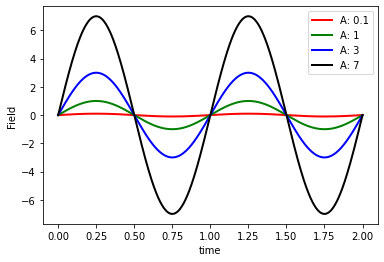

In [7]:
#Define field process
time_vec = np.linspace(0, 2, 500)
A = [0.1, 1, 3, 7]
color=['r','g','b','k']
for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    cs =color[proc]
    plt.plot(time_vec, E, cs, linewidth=2, label = "A: "+str(A[proc]))

plt.xlabel("time")
plt.ylabel("Field")
plt.legend(loc="best")
plt.show()

<h1>Generate a sample hysteresis loop

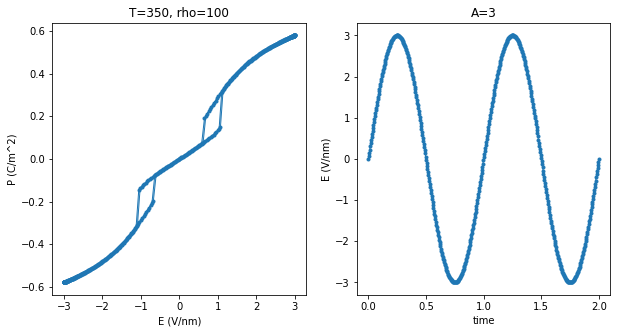

In [9]:
# Loop Structure Analysis, for a fixed parameter space of T and rho, given a fixed amplitude of field.
#Change the amplitude to get better visualization of the loops if required.
time_vec = np.linspace(0, 2, 500)
A = 3
E = A * np.sin(2 * np.pi * time_vec)
T = 350
rho = 10**2
Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, rho, 5, 0.2, E)
#print(objeval)


# Plot Hysteresis Loop
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(E, Pmat, 'o-', linewidth=1, markersize=3)
ax[0].set_xlabel('E (V/nm)')
ax[0].set_ylabel('P (C/m^2)')
ax[0].set_title("T=" + str(T) +", rho=" +str(rho))
ax[1].plot(time_vec, E, 'o-', linewidth=1, markersize=3)
ax[1].set_xlabel('time')
ax[1].set_ylabel('E (V/nm)')
ax[1].set_title("A=" + str(A))
plt.show()
    

Low Sampling exhaustive search

Parameter space:

Temperature, $T (K)=[250,300,350,400,450,500,550]$

Partial O2 pressure, $rho=[10^0,10^1,10^2,10^3,10^4,10^5,10^6]$

Other parameter (fixed values):
film thickness, $h = 5$ nm
surface ion energy, $\Delta_G = 0.2$ eV

Process:1; Analysis:1
Process:1; Analysis:2
Process:1; Analysis:3
Process:1; Analysis:4
Process:1; Analysis:5
Process:1; Analysis:6
Process:1; Analysis:7
Process:1; Analysis:8
Process:1; Analysis:9
Process:1; Analysis:10
Process:1; Analysis:11
Process:1; Analysis:12
Process:1; Analysis:13
Process:1; Analysis:14
Process:1; Analysis:15
Process:1; Analysis:16
Process:1; Analysis:17
Process:1; Analysis:18
Process:1; Analysis:19
Process:1; Analysis:20
Process:1; Analysis:21
Process:1; Analysis:22
Process:1; Analysis:23
Process:1; Analysis:24
Process:1; Analysis:25
Process:1; Analysis:26
Process:1; Analysis:27
Process:1; Analysis:28
Process:1; Analysis:29
Process:1; Analysis:30
Process:1; Analysis:31
Process:1; Analysis:32
Process:1; Analysis:33
Process:1; Analysis:34
Process:1; Analysis:35
Process:1; Analysis:36
Process:1; Analysis:37
Process:1; Analysis:38
Process:1; Analysis:39
Process:1; Analysis:40
Process:1; Analysis:41
Process:1; Analysis:42
Process:1; Analysis:43
Process:1; Analysis:

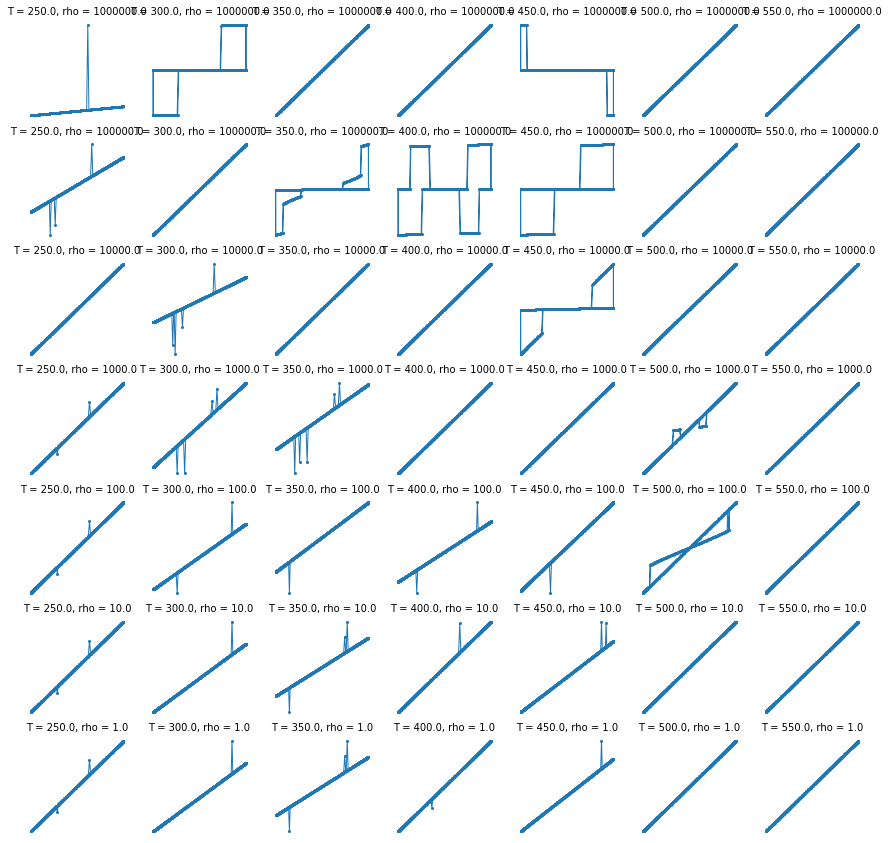

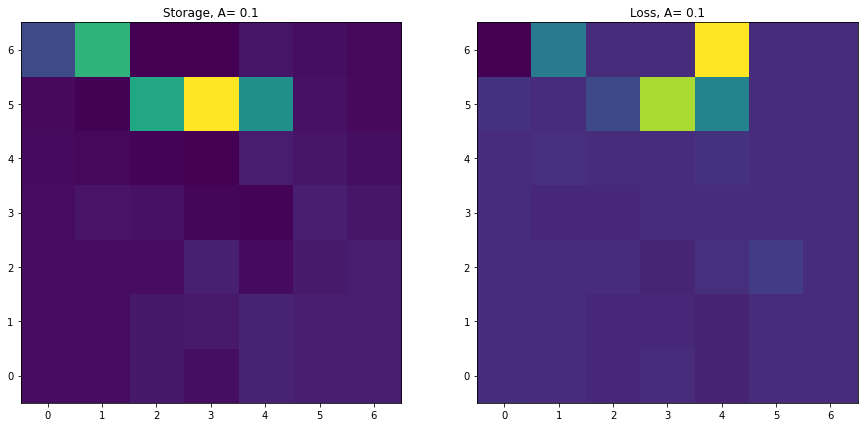

Process:2; Analysis:1
Process:2; Analysis:2
Process:2; Analysis:3
Process:2; Analysis:4
Process:2; Analysis:5
Process:2; Analysis:6
Process:2; Analysis:7
Process:2; Analysis:8
Process:2; Analysis:9
Process:2; Analysis:10
Process:2; Analysis:11
Process:2; Analysis:12
Process:2; Analysis:13
Process:2; Analysis:14
Process:2; Analysis:15
Process:2; Analysis:16
Process:2; Analysis:17
Process:2; Analysis:18
Process:2; Analysis:19
Process:2; Analysis:20
Process:2; Analysis:21
Process:2; Analysis:22
Process:2; Analysis:23
Process:2; Analysis:24
Process:2; Analysis:25
Process:2; Analysis:26
Process:2; Analysis:27
Process:2; Analysis:28
Process:2; Analysis:29
Process:2; Analysis:30
Process:2; Analysis:31
Process:2; Analysis:32
Process:2; Analysis:33
Process:2; Analysis:34
Process:2; Analysis:35
Process:2; Analysis:36
Process:2; Analysis:37
Process:2; Analysis:38
Process:2; Analysis:39
Process:2; Analysis:40
Process:2; Analysis:41
Process:2; Analysis:42
Process:2; Analysis:43
Process:2; Analysis:

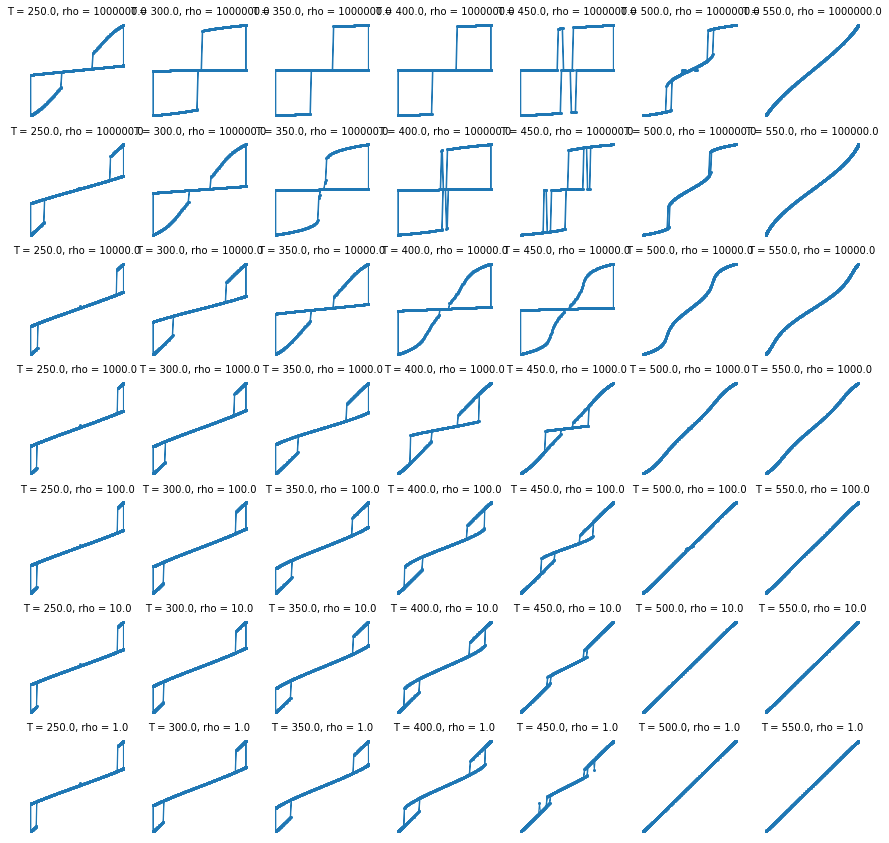

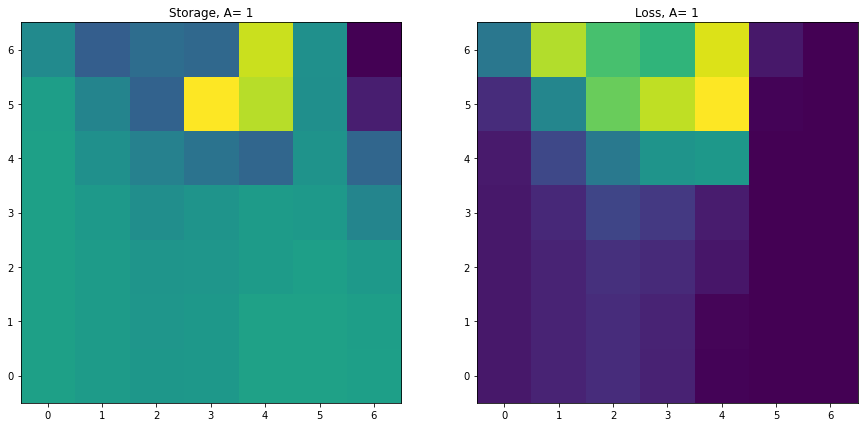

Process:3; Analysis:1
Process:3; Analysis:2
Process:3; Analysis:3
Process:3; Analysis:4
Process:3; Analysis:5
Process:3; Analysis:6
Process:3; Analysis:7
Process:3; Analysis:8
Process:3; Analysis:9
Process:3; Analysis:10
Process:3; Analysis:11
Process:3; Analysis:12
Process:3; Analysis:13
Process:3; Analysis:14
Process:3; Analysis:15
Process:3; Analysis:16
Process:3; Analysis:17
Process:3; Analysis:18
Process:3; Analysis:19
Process:3; Analysis:20
Process:3; Analysis:21
Process:3; Analysis:22
Process:3; Analysis:23
Process:3; Analysis:24
Process:3; Analysis:25
Process:3; Analysis:26
Process:3; Analysis:27
Process:3; Analysis:28
Process:3; Analysis:29
Process:3; Analysis:30
Process:3; Analysis:31
Process:3; Analysis:32
Process:3; Analysis:33
Process:3; Analysis:34
Process:3; Analysis:35
Process:3; Analysis:36
Process:3; Analysis:37
Process:3; Analysis:38
Process:3; Analysis:39
Process:3; Analysis:40
Process:3; Analysis:41
Process:3; Analysis:42
Process:3; Analysis:43
Process:3; Analysis:

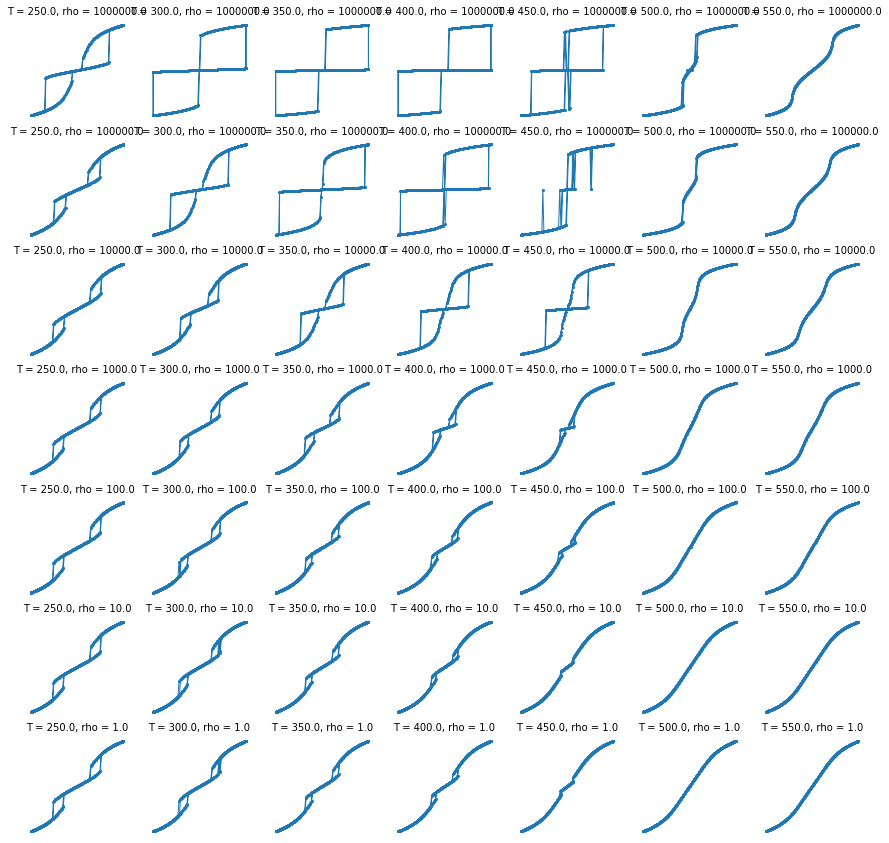

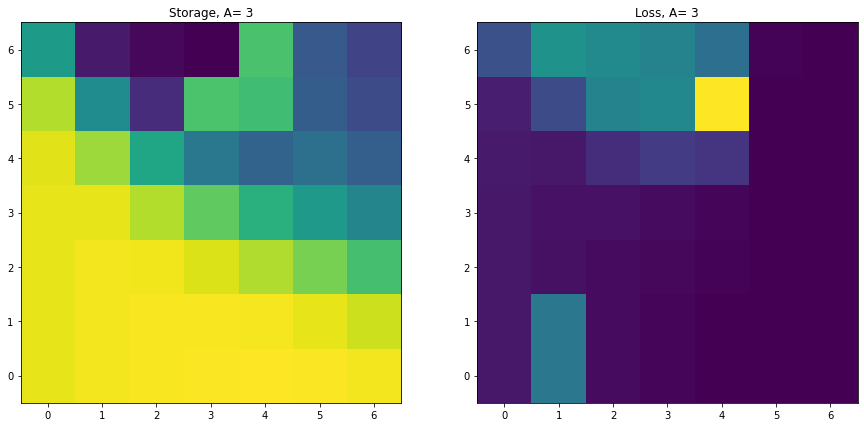

Process:4; Analysis:1
Process:4; Analysis:2
Process:4; Analysis:3
Process:4; Analysis:4
Process:4; Analysis:5
Process:4; Analysis:6
Process:4; Analysis:7
Process:4; Analysis:8
Process:4; Analysis:9
Process:4; Analysis:10
Process:4; Analysis:11
Process:4; Analysis:12
Process:4; Analysis:13
Process:4; Analysis:14
Process:4; Analysis:15
Process:4; Analysis:16
Process:4; Analysis:17
Process:4; Analysis:18
Process:4; Analysis:19
Process:4; Analysis:20
Process:4; Analysis:21
Process:4; Analysis:22
Process:4; Analysis:23
Process:4; Analysis:24
Process:4; Analysis:25
Process:4; Analysis:26
Process:4; Analysis:27
Process:4; Analysis:28
Process:4; Analysis:29
Process:4; Analysis:30
Process:4; Analysis:31
Process:4; Analysis:32
Process:4; Analysis:33
Process:4; Analysis:34
Process:4; Analysis:35
Process:4; Analysis:36
Process:4; Analysis:37
Process:4; Analysis:38
Process:4; Analysis:39
Process:4; Analysis:40
Process:4; Analysis:41
Process:4; Analysis:42
Process:4; Analysis:43
Process:4; Analysis:

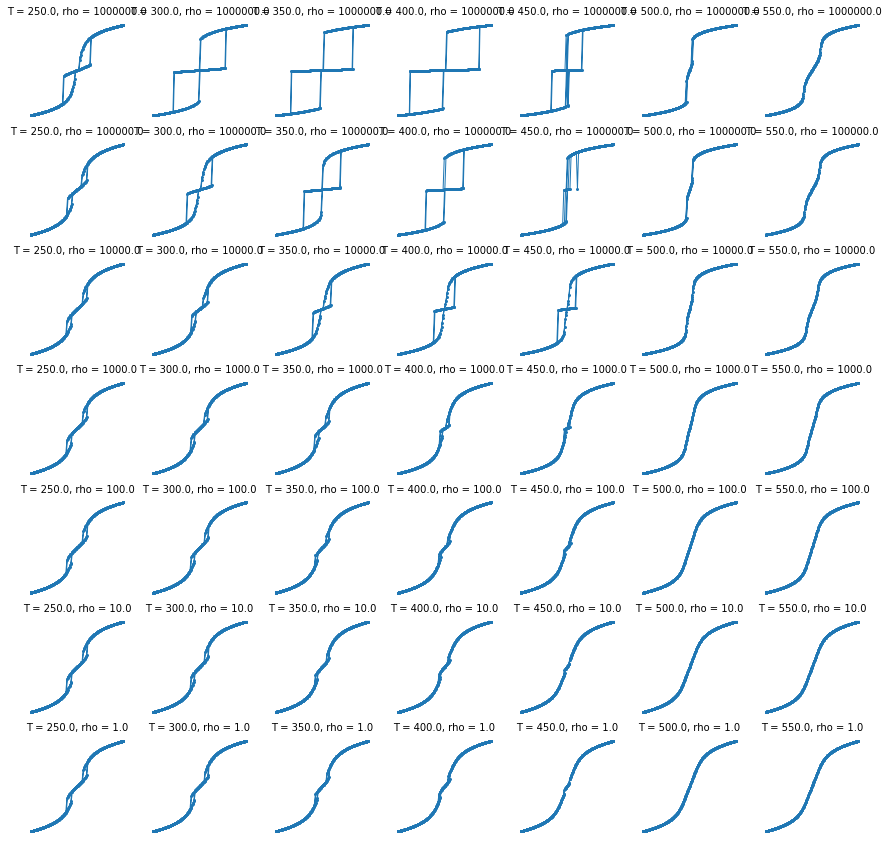

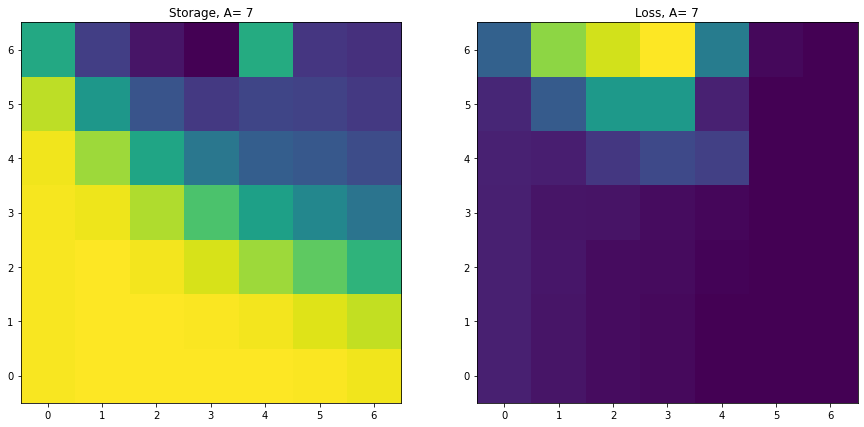

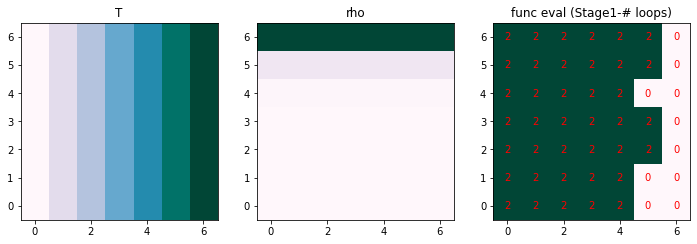

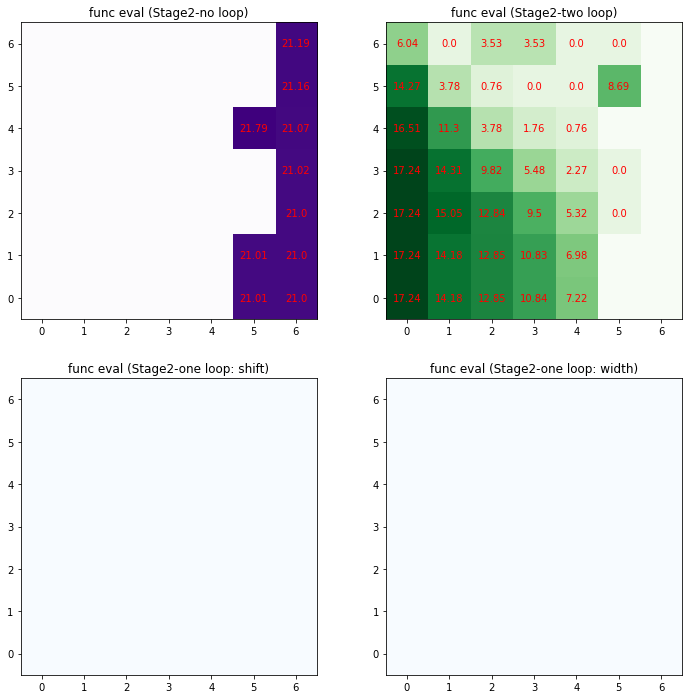

In [19]:
time_vec = np.linspace(0, 2, 500)
A = [0.1, 1, 3, 7]

num_rows =7
max_hysplot_dim =10 # With denser maps, the hysteresis loop grid image will get very messy and thus redundant to plot. Thus, we toogle off the full hysteresis plot if the dim>10. Instead we can plot hysteresis loop separately in the previous code segment
toggle_num_dim =10  # With denser maps, the numbers in the heatmap of phase diag will get very messy and thus redundant to plot. Thus, we toogle off if the dim>10. We can get good visualization with color intensity with denser maps
Temp = np.linspace(250, 550, num_rows)
n= np.linspace(0, 6, num_rows)
#n=int(n)
rho = np.zeros(len(n))
for i in range(0, len(n)):
    rho[i] = 10**(n[i])

#Temp=[500, 550]
#rho=[10**7, 10**8]

objphaseS1 = np.zeros((len(Temp), len(Temp)))
objphaseS1A =np.zeros((len(Temp)**2,len(A)))
objphasesS2C1 = np.zeros((len(Temp), len(Temp)))
objphasesS2C2 = np.zeros((len(Temp), len(Temp)))
objphaseS2C1A =np.zeros((len(Temp)**2,len(A)))
objphaseS2C2A =np.zeros((len(Temp)**2,len(A)))
Storage = np.zeros((len(Temp), len(Temp)))
StorageA =np.zeros((len(Temp)**2,len(A)))
Loss = np.zeros((len(Temp), len(Temp)))
LossA =np.zeros((len(Temp)**2,len(A)))
Temp,rho = np.meshgrid(Temp, rho)


for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    m=0
    if (num_rows<=max_hysplot_dim):
        fig1, ax1 = plt.subplots(len(Temp), len(Temp), figsize=(15,15))

    for t1, (x1, x2) in enumerate(zip(Temp, rho)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
            m=m+1
            print("Process:" +str(proc+1)+"; Analysis:"+str(m))
            #arguments of funoptimize(T, rho, h, deltaG, E)
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(xx1, xx2, 5, 0.2, E)
            objphaseS1[t1, t2] = objeval #Stage 1 evaluation
            objphasesS2C1[t1, t2] = objeval2 #Stage 2 -Criteria 1: One loop- Storage Energy
            objphasesS2C2[t1, t2] = objeval3 #Stage 2- Criteria 2: One loop- Loop Shift/Width
            Storage[t1, t2] = ES
            Loss[t1, t2] =EL
            if (num_rows<=max_hysplot_dim):
            #Plot for hysteresis loops at each region for each A
            #input arguments in order: fig1, ax1, full grid numpy array of 2 control params, numpy array of field process, scalar value of control params for which the hysteresis loops are created, iteration t1(row) and t2(col), 
            # string name of control params, linewidth, markersize and fontsize
                fig1, ax1 = plot_hysteresis(fig1, ax1, Temp, rho, E, Pmat, xx1, xx2, t1, t2, 'T','rho', 1, 2, 10)


    plt.show()
    objphaseS1A[:,proc]= np.reshape(objphaseS1, (len(Temp)**2))
    objphaseS2C1A[:, proc] = np.reshape(objphasesS2C1, (len(Temp) ** 2))
    objphaseS2C2A[:, proc] = np.reshape(objphasesS2C2, (len(Temp) ** 2))
    StorageA[:, proc] = np.reshape(Storage, (len(Temp) ** 2))
    LossA[:, proc] = np.reshape(Loss, (len(Temp) ** 2))

    #Plot Storage and loss grid image for each A
    #input arguments in order: full grid numpy array of Storage and loss, num of rows in each dimension of grid, toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree,
    # A[proc] is the amplitude of the field process 
    plot_Storage_Loss(Storage, Loss, num_rows, toggle_num_dim, A[proc])


## Generate phase matrix and plot phases for Stage 1 and Stage 2
phaseS1, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop= phase_matrix(Temp, rho, objphaseS1A, objphaseS2C1A, objphaseS2C2A, num_rows, toggle_num_dim, 'T','rho')



Low Sampling exhaustive search

Parameter space:

Temperature, $T (K)=[250,300,350,400,450,500,550]$

Partial O2 pressure, $rho=[10^2,10^3,10^4,10^5,10^6,10^7,10^8]$

Other parameter (fixed values):
film thickness, $h = 50$ nm
surface ion energy, $\Delta_G = 0.2$ eV

Process:1; Analysis:1
Process:1; Analysis:2
Process:1; Analysis:3
Process:1; Analysis:4
Process:1; Analysis:5
Process:1; Analysis:6
Process:1; Analysis:7
Process:1; Analysis:8
Process:1; Analysis:9
Process:1; Analysis:10
Process:1; Analysis:11
Process:1; Analysis:12
Process:1; Analysis:13
Process:1; Analysis:14
Process:1; Analysis:15
Process:1; Analysis:16
Process:1; Analysis:17
Process:1; Analysis:18
Process:1; Analysis:19
Process:1; Analysis:20
Process:1; Analysis:21
Process:1; Analysis:22
Process:1; Analysis:23
Process:1; Analysis:24
Process:1; Analysis:25
Process:1; Analysis:26
Process:1; Analysis:27
Process:1; Analysis:28
Process:1; Analysis:29
Process:1; Analysis:30
Process:1; Analysis:31
Process:1; Analysis:32
Process:1; Analysis:33
Process:1; Analysis:34
Process:1; Analysis:35
Process:1; Analysis:36
Process:1; Analysis:37
Process:1; Analysis:38
Process:1; Analysis:39
Process:1; Analysis:40
Process:1; Analysis:41
Process:1; Analysis:42
Process:1; Analysis:43
Process:1; Analysis:

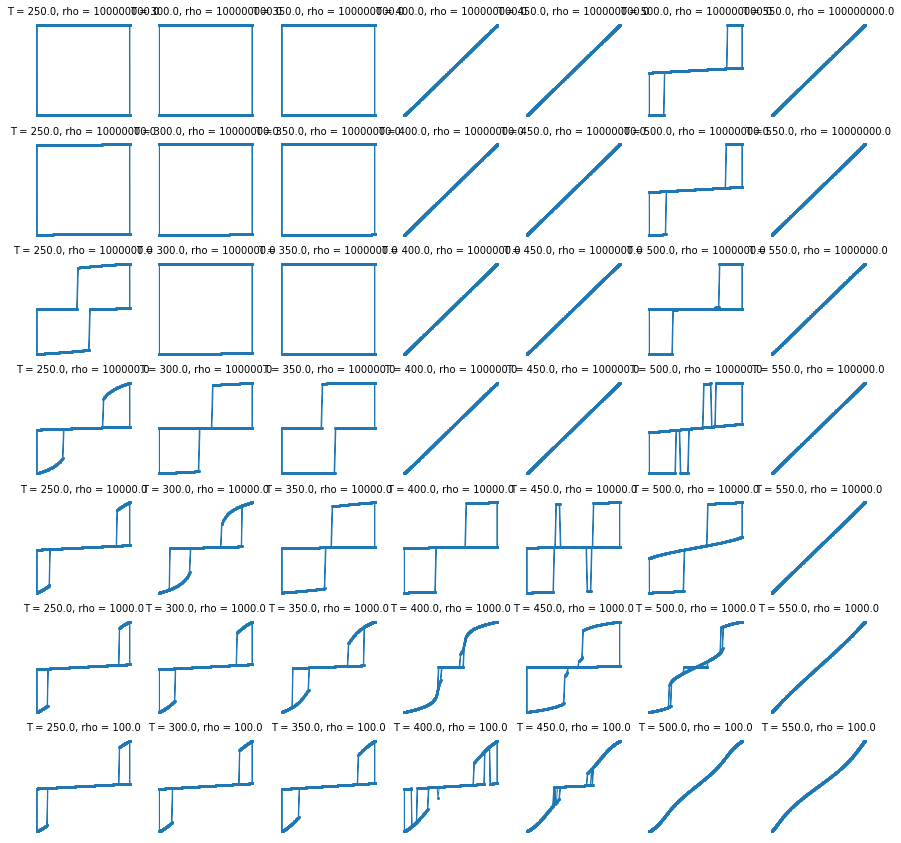

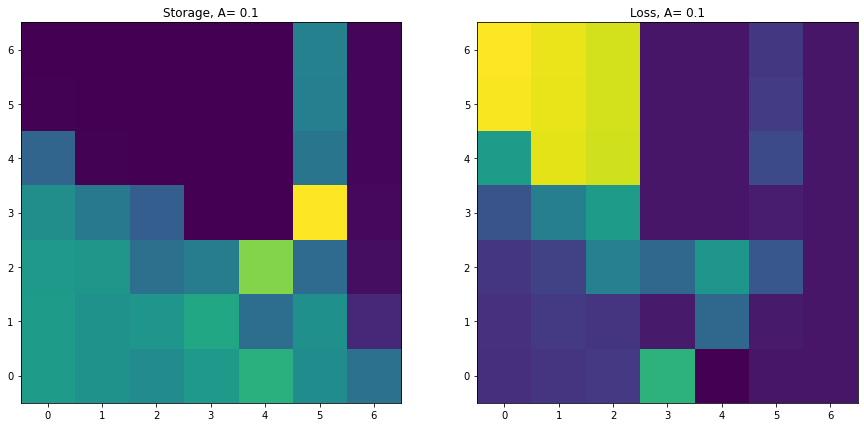

Process:2; Analysis:1
Process:2; Analysis:2
Process:2; Analysis:3
Process:2; Analysis:4
Process:2; Analysis:5
Process:2; Analysis:6
Process:2; Analysis:7
Process:2; Analysis:8
Process:2; Analysis:9
Process:2; Analysis:10
Process:2; Analysis:11
Process:2; Analysis:12
Process:2; Analysis:13
Process:2; Analysis:14
Process:2; Analysis:15
Process:2; Analysis:16
Process:2; Analysis:17
Process:2; Analysis:18
Process:2; Analysis:19
Process:2; Analysis:20
Process:2; Analysis:21
Process:2; Analysis:22
Process:2; Analysis:23
Process:2; Analysis:24
Process:2; Analysis:25
Process:2; Analysis:26
Process:2; Analysis:27
Process:2; Analysis:28
Process:2; Analysis:29
Process:2; Analysis:30
Process:2; Analysis:31
Process:2; Analysis:32
Process:2; Analysis:33
Process:2; Analysis:34
Process:2; Analysis:35
Process:2; Analysis:36
Process:2; Analysis:37
Process:2; Analysis:38
Process:2; Analysis:39
Process:2; Analysis:40
Process:2; Analysis:41
Process:2; Analysis:42
Process:2; Analysis:43
Process:2; Analysis:

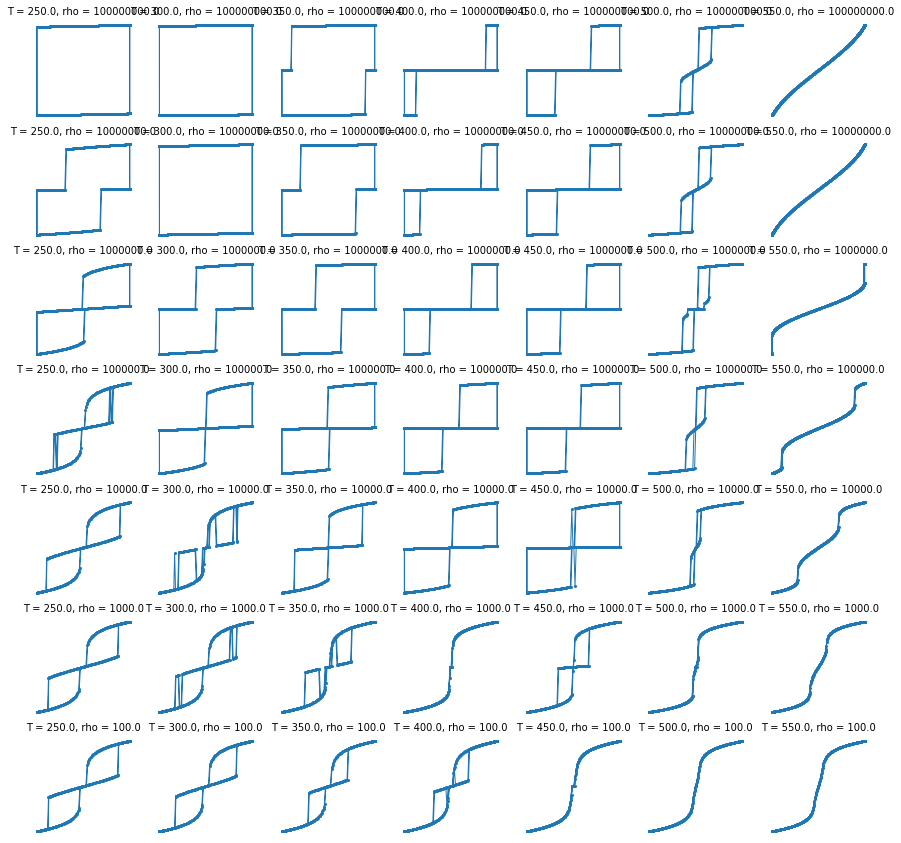

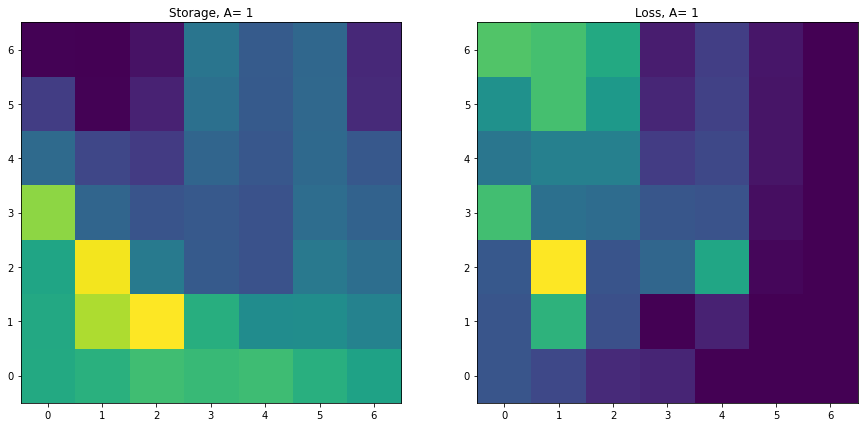

Process:3; Analysis:1
Process:3; Analysis:2
Process:3; Analysis:3
Process:3; Analysis:4
Process:3; Analysis:5
Process:3; Analysis:6
Process:3; Analysis:7
Process:3; Analysis:8
Process:3; Analysis:9
Process:3; Analysis:10
Process:3; Analysis:11
Process:3; Analysis:12
Process:3; Analysis:13
Process:3; Analysis:14
Process:3; Analysis:15
Process:3; Analysis:16
Process:3; Analysis:17
Process:3; Analysis:18
Process:3; Analysis:19
Process:3; Analysis:20
Process:3; Analysis:21
Process:3; Analysis:22
Process:3; Analysis:23
Process:3; Analysis:24
Process:3; Analysis:25
Process:3; Analysis:26
Process:3; Analysis:27
Process:3; Analysis:28
Process:3; Analysis:29
Process:3; Analysis:30
Process:3; Analysis:31
Process:3; Analysis:32
Process:3; Analysis:33
Process:3; Analysis:34
Process:3; Analysis:35
Process:3; Analysis:36
Process:3; Analysis:37
Process:3; Analysis:38
Process:3; Analysis:39
Process:3; Analysis:40
Process:3; Analysis:41
Process:3; Analysis:42
Process:3; Analysis:43
Process:3; Analysis:

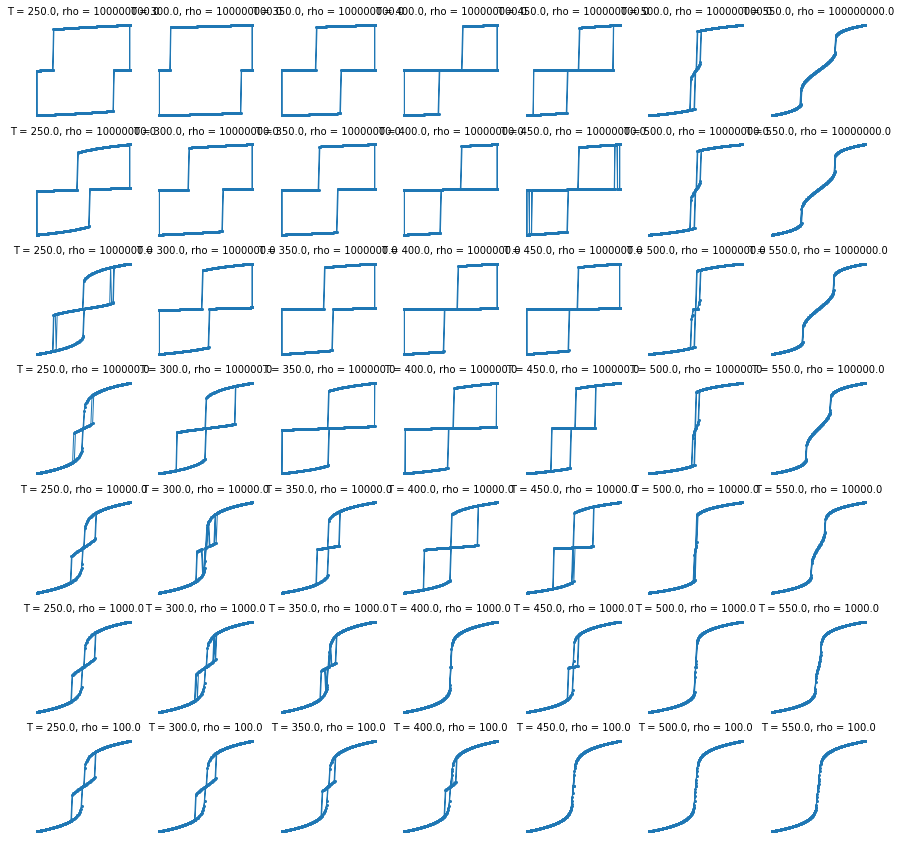

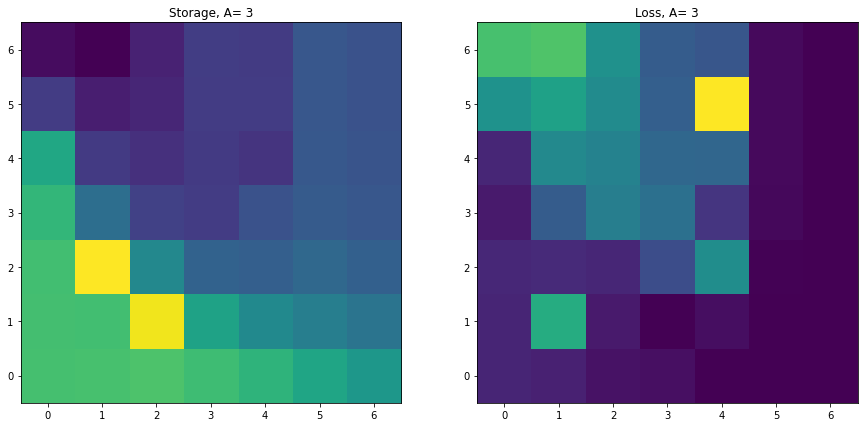

Process:4; Analysis:1
Process:4; Analysis:2
Process:4; Analysis:3
Process:4; Analysis:4
Process:4; Analysis:5
Process:4; Analysis:6
Process:4; Analysis:7
Process:4; Analysis:8
Process:4; Analysis:9
Process:4; Analysis:10
Process:4; Analysis:11
Process:4; Analysis:12
Process:4; Analysis:13
Process:4; Analysis:14
Process:4; Analysis:15
Process:4; Analysis:16
Process:4; Analysis:17
Process:4; Analysis:18
Process:4; Analysis:19
Process:4; Analysis:20
Process:4; Analysis:21
Process:4; Analysis:22
Process:4; Analysis:23
Process:4; Analysis:24
Process:4; Analysis:25
Process:4; Analysis:26
Process:4; Analysis:27
Process:4; Analysis:28
Process:4; Analysis:29
Process:4; Analysis:30
Process:4; Analysis:31
Process:4; Analysis:32
Process:4; Analysis:33
Process:4; Analysis:34
Process:4; Analysis:35
Process:4; Analysis:36
Process:4; Analysis:37
Process:4; Analysis:38
Process:4; Analysis:39
Process:4; Analysis:40
Process:4; Analysis:41
Process:4; Analysis:42
Process:4; Analysis:43
Process:4; Analysis:

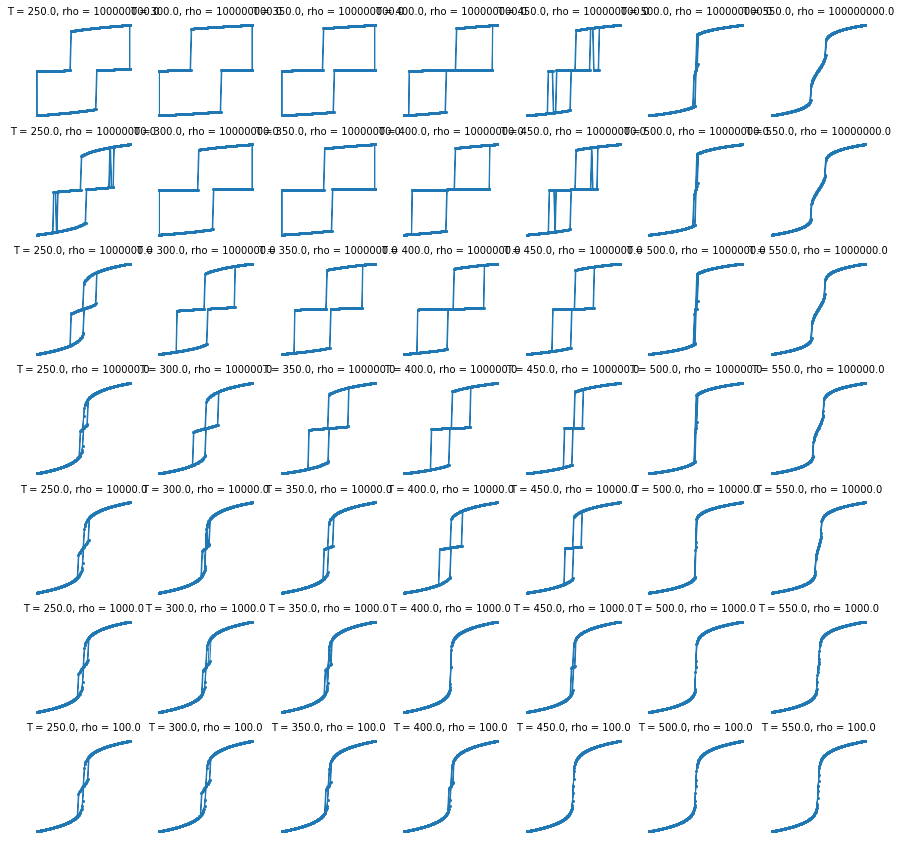

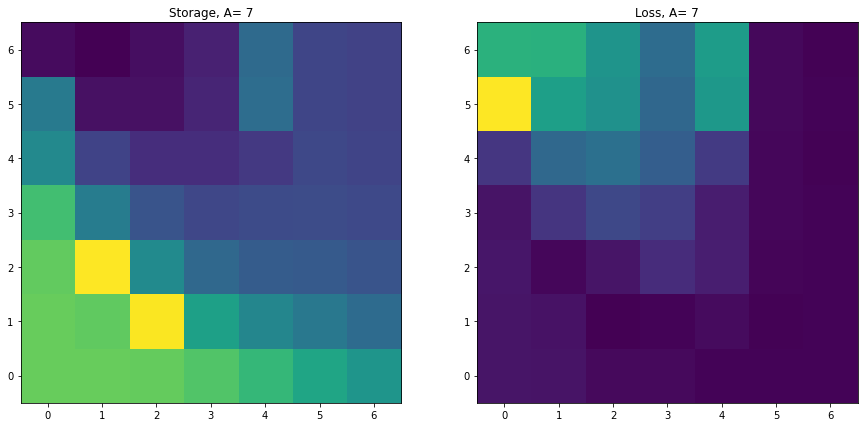

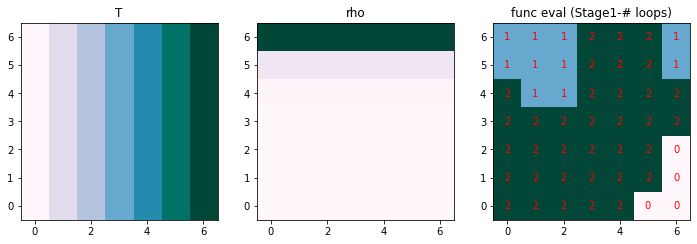

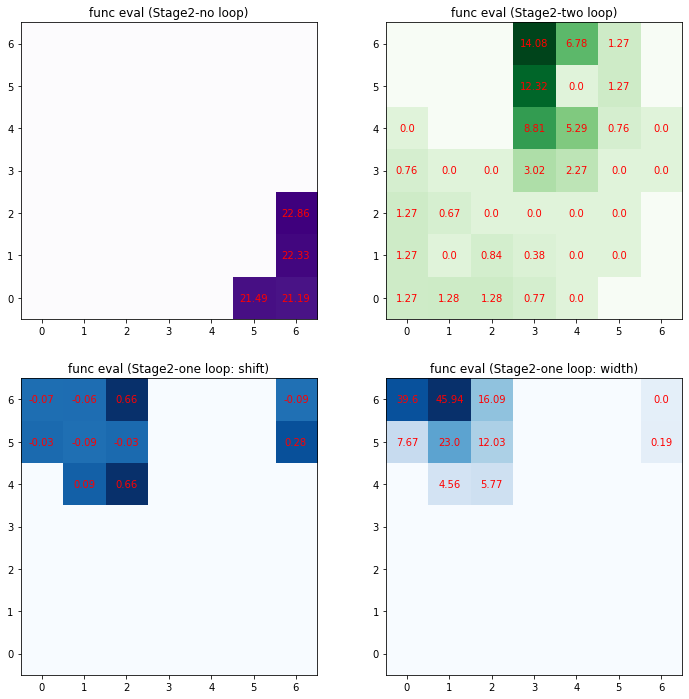

In [20]:
time_vec = np.linspace(0, 2, 500)
A = [0.1, 1, 3, 7]

num_rows =7
max_hysplot_dim =10 # With denser maps, the hysteresis loop grid image will get very messy and thus redundant to plot. Thus, we toogle off the full hysteresis plot if the dim>10. Instead we can plot hysteresis loop separately in the previous code segment
toggle_num_dim =10  # With denser maps, the numbers in the heatmap of phase diag will get very messy and thus redundant to plot. Thus, we toogle off if the dim>10. We can get good visualization with color intensity with denser maps
Temp = np.linspace(250, 550, num_rows)
n= np.linspace(2, 8, num_rows)
#n=int(n)
rho = np.zeros(len(n))
for i in range(0, len(n)):
    rho[i] = 10**(n[i])

#Temp=[500, 550]
#rho=[10**7, 10**8]

objphaseS1 = np.zeros((len(Temp), len(Temp)))
objphaseS1A =np.zeros((len(Temp)**2,len(A)))
objphasesS2C1 = np.zeros((len(Temp), len(Temp)))
objphasesS2C2 = np.zeros((len(Temp), len(Temp)))
objphaseS2C1A =np.zeros((len(Temp)**2,len(A)))
objphaseS2C2A =np.zeros((len(Temp)**2,len(A)))
Storage = np.zeros((len(Temp), len(Temp)))
StorageA =np.zeros((len(Temp)**2,len(A)))
Loss = np.zeros((len(Temp), len(Temp)))
LossA =np.zeros((len(Temp)**2,len(A)))
Temp,rho = np.meshgrid(Temp, rho)


for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    m=0
    if (num_rows<=max_hysplot_dim):
        fig1, ax1 = plt.subplots(len(Temp), len(Temp), figsize=(15,15))

    for t1, (x1, x2) in enumerate(zip(Temp, rho)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
            m=m+1
            print("Process:" +str(proc+1)+"; Analysis:"+str(m))
            #arguments of funoptimize(T, rho, h, deltaG, E)
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(xx1, xx2, 50, 0.2, E)
            objphaseS1[t1, t2] = objeval #Stage 1 evaluation
            objphasesS2C1[t1, t2] = objeval2 #Stage 2 -Criteria 1: One loop- Storage Energy
            objphasesS2C2[t1, t2] = objeval3 #Stage 2- Criteria 2: One loop- Loop Shift/Width
            Storage[t1, t2] = ES
            Loss[t1, t2] =EL
            if (num_rows<=max_hysplot_dim):
            #Plot for hysteresis loops at each region for each A
            #input arguments in order: fig1, ax1, full grid numpy array of 2 control params, numpy array of field process, scalar value of control params for which the hysteresis loops are created, iteration t1(row) and t2(col), 
            # string name of control params, linewidth, markersize and fontsize
                fig1, ax1 = plot_hysteresis(fig1, ax1, Temp, rho, E, Pmat, xx1, xx2, t1, t2, 'T','rho', 1, 2, 10)


    plt.show()
    objphaseS1A[:,proc]= np.reshape(objphaseS1, (len(Temp)**2))
    objphaseS2C1A[:, proc] = np.reshape(objphasesS2C1, (len(Temp) ** 2))
    objphaseS2C2A[:, proc] = np.reshape(objphasesS2C2, (len(Temp) ** 2))
    StorageA[:, proc] = np.reshape(Storage, (len(Temp) ** 2))
    LossA[:, proc] = np.reshape(Loss, (len(Temp) ** 2))

    #Plot Storage and loss grid image for each A
    #input arguments in order: full grid numpy array of Storage and loss, num of rows in each dimension of grid, toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree,
    # A[proc] is the amplitude of the field process 
    plot_Storage_Loss(Storage, Loss, num_rows, toggle_num_dim, A[proc])


## Generate phase matrix and plot phases for Stage 1 and Stage 2
phaseS1, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop= phase_matrix(Temp, rho, objphaseS1A, objphaseS2C1A, objphaseS2C2A, num_rows, toggle_num_dim, 'T','rho')



The loop structure is configured using downhill simplex algorithm in scipy python package (optimize.fmin) to find the desired local minima of polarization (P) over the objective of free energy (F), depending on the field history, at each value of field, E(t) in the time-steps. Some of the loops are ill-configured due to the convergence issue of the algorithm (stuck to sub-optima or any undesired local optima region). It is generally a hard problem to choose the optimization algorithm, even harder when we aim for a specific local or global minima. 